In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
notebook = "real1_Abalone"

In [5]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
X = X.drop(columns=['Sex'])

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
ndpost = 10000
nskip = 0
n_trees = 100

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
proposal_probs_default = {
    'grow': 0.25,
    'prune': 0.25,
    'change': 0.4,
    'swap': 0.1
}
bart = DefaultBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_default, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_default.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_default.npy', np.array(rmses))

Iterations: 100%|██████████| 10000/10000 [02:24<00:00, 69.10it/s]


In [10]:
proposal_probs_mtmh = {
    'multi_grow': 0.25,
    'multi_prune': 0.25,
    'multi_change': 0.4,
    'multi_swap': 0.1
}
bart = MultiBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_mtmh, multi_tries=10, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_mtmh.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_mtmh.npy', np.array(rmses))

Iterations: 100%|██████████| 10000/10000 [15:27<00:00, 10.78it/s]


In [11]:
from diagnosis import segmented_ljung_box_test, segment_ess_efficiency

## Default
### Ljung-Box test

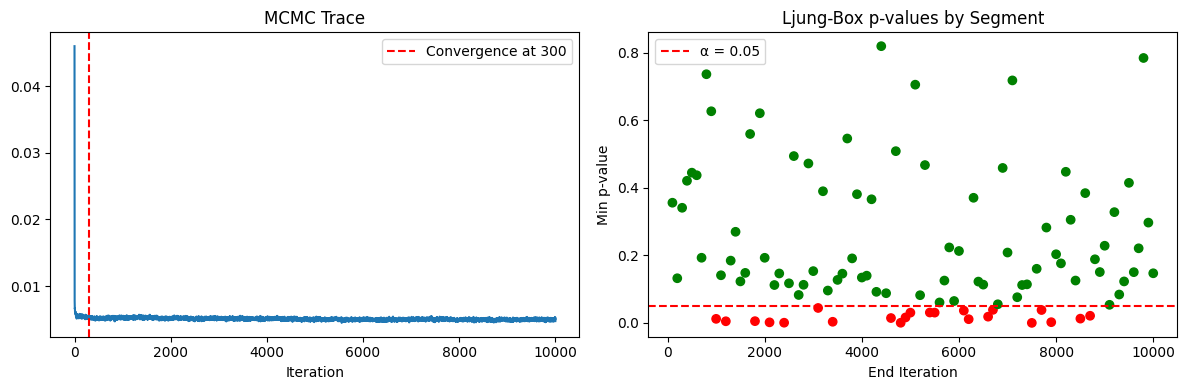

Chain converged: True
Convergence at iteration: 300
Convergence rate: 78.00%


In [12]:
# Diagnose default sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


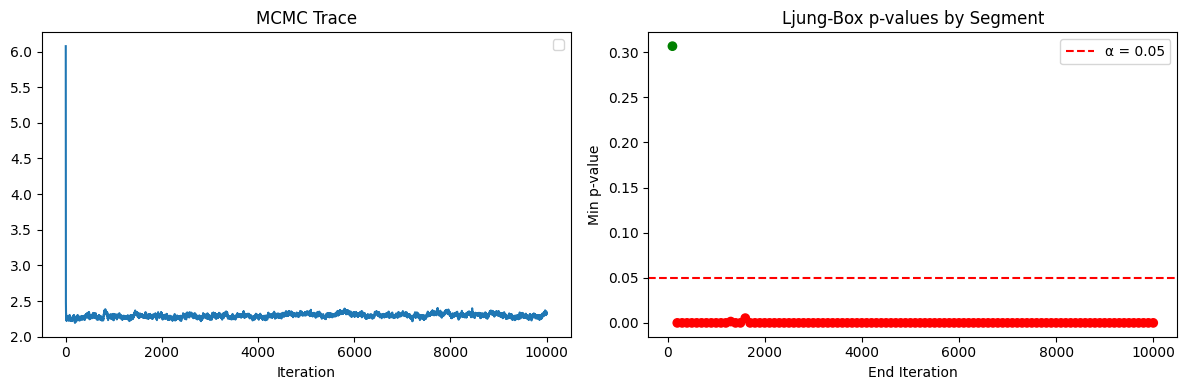

Chain converged: False
Convergence rate: 1.00%


In [13]:
# Diagnose default rmse convergence
rmses = np.load(f'store/{notebook}_rmses_default.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

### ESS

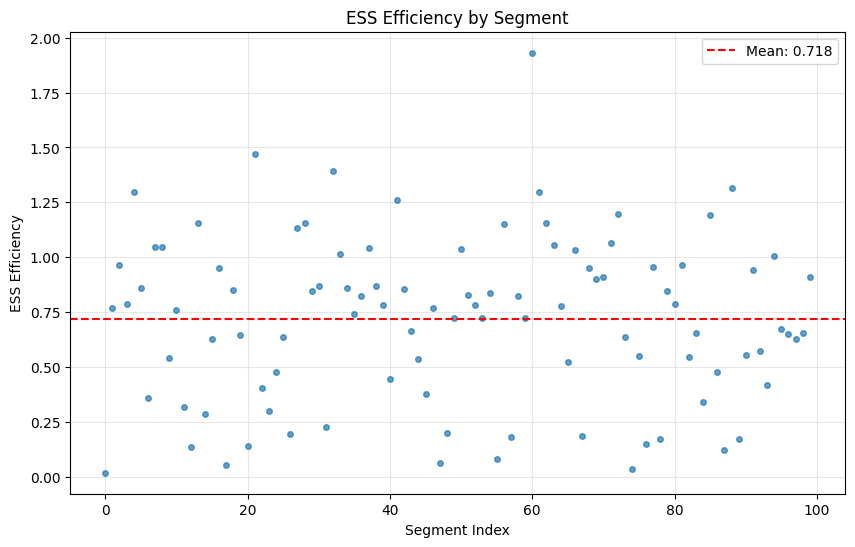

In [14]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

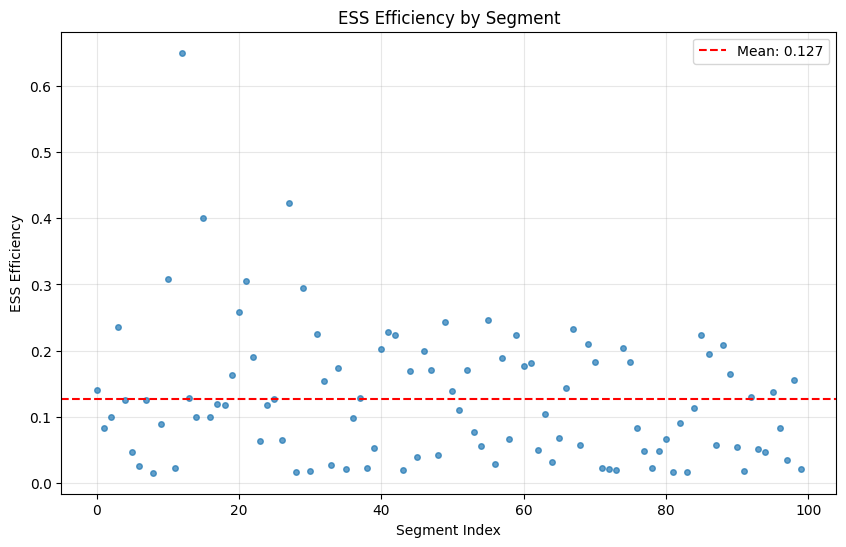

In [15]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

In [9]:
from diagnosis import plot_autocorrelation

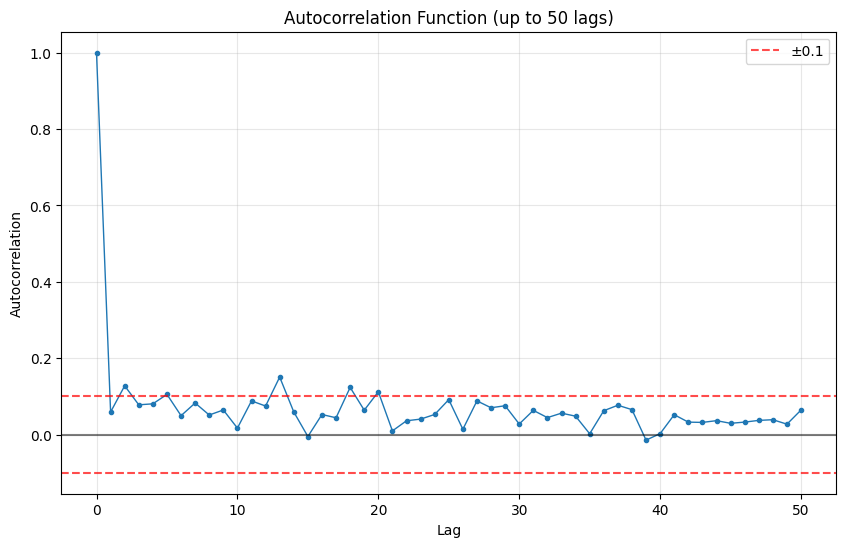

array([ 1.        ,  0.0589701 ,  0.12764711,  0.077825  ,  0.08044672,
        0.10519897,  0.04942417,  0.08262149,  0.05115381,  0.06433602,
        0.01683828,  0.0880773 ,  0.07465961,  0.15058486,  0.05922392,
       -0.00515316,  0.05246661,  0.04390764,  0.12345518,  0.06379716,
        0.11200935,  0.00958732,  0.0360618 ,  0.04042504,  0.05255297,
        0.09140486,  0.01377407,  0.08817035,  0.07014033,  0.07541565,
        0.02759272,  0.0633108 ,  0.04434371,  0.05604502,  0.04806127,
        0.00205471,  0.06244434,  0.0767172 ,  0.06519204, -0.01460371,
        0.00240429,  0.0519404 ,  0.03247893,  0.03179451,  0.03634942,
        0.0294056 ,  0.03259253,  0.03705918,  0.03884703,  0.02714861,
        0.064243  ])

In [10]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

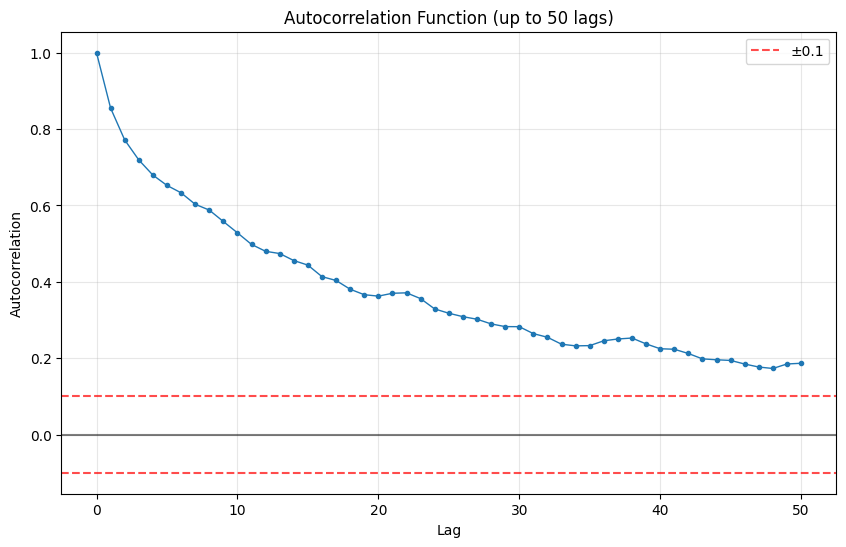

array([1.        , 0.85501025, 0.77165518, 0.71923181, 0.67953475,
       0.65248841, 0.63313893, 0.60315128, 0.58791551, 0.55802309,
       0.52835948, 0.4979667 , 0.47987697, 0.47405067, 0.45568195,
       0.4437624 , 0.4135113 , 0.40355232, 0.3806078 , 0.36621052,
       0.36252279, 0.36998921, 0.37115578, 0.35593796, 0.32892576,
       0.31773159, 0.30874473, 0.30202852, 0.28983494, 0.28267391,
       0.28249219, 0.264346  , 0.25477341, 0.23659927, 0.23224808,
       0.23288041, 0.24553137, 0.25025426, 0.25276149, 0.23740602,
       0.22470076, 0.2234121 , 0.21226669, 0.19820069, 0.19581395,
       0.19408224, 0.18467637, 0.17680063, 0.17299455, 0.18481843,
       0.1866291 ])

In [11]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)

## MTMH
### Ljung-Box test

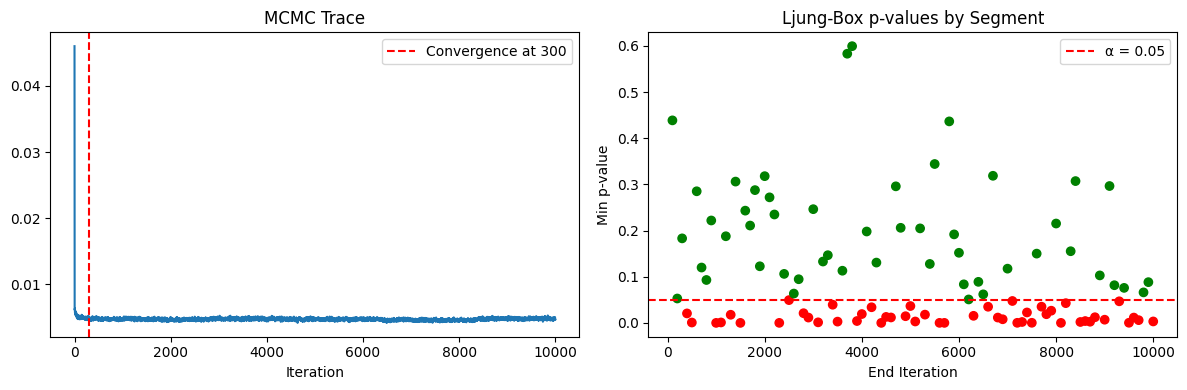

Chain converged: True
Convergence at iteration: 300
Convergence rate: 51.00%


In [16]:
# Diagnose mtmh sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


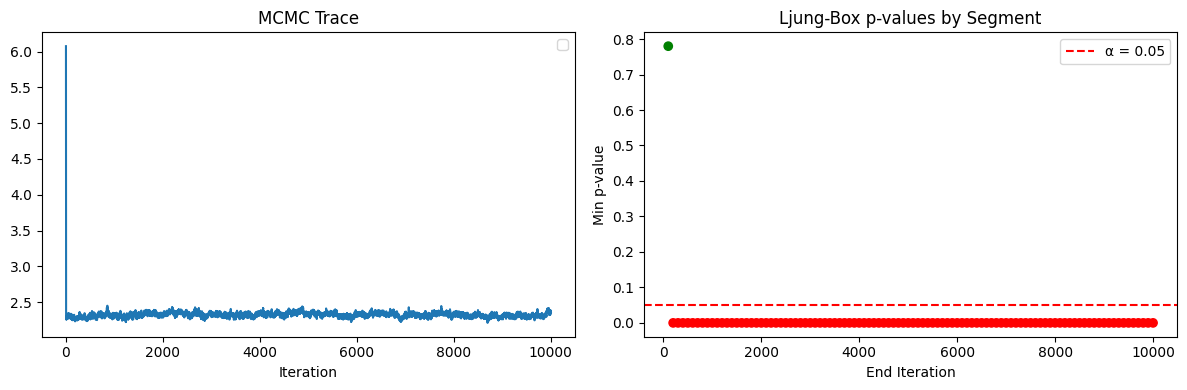

Chain converged: False
Convergence rate: 1.00%


In [17]:
# Diagnose mtmh rmse convergence
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

### ESS

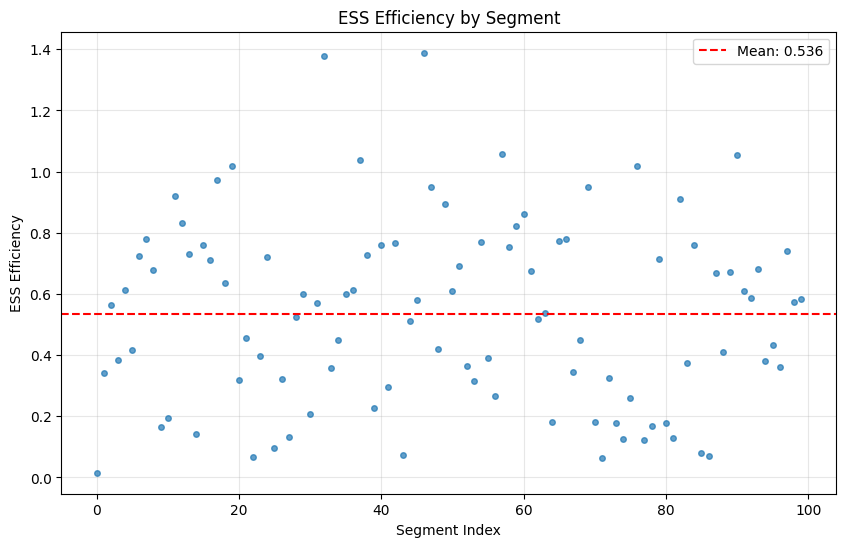

In [18]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=100)

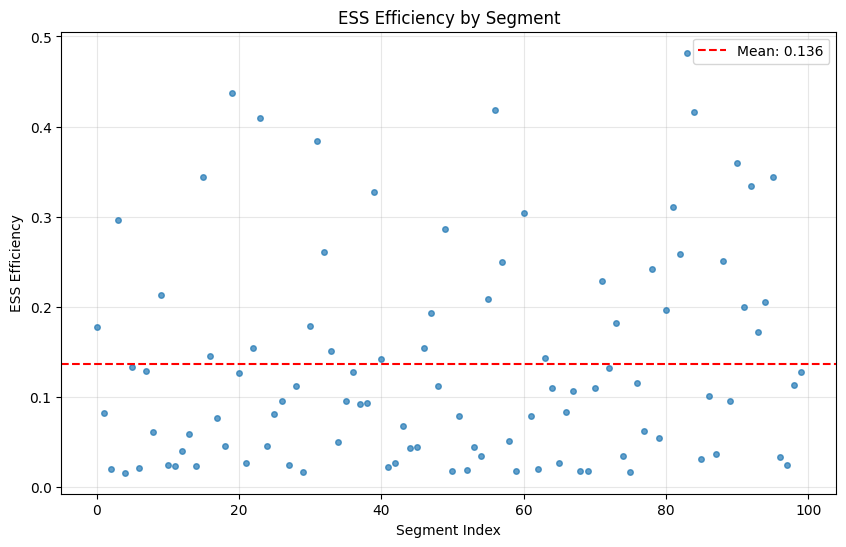

In [19]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=100)

### Autocorrelation

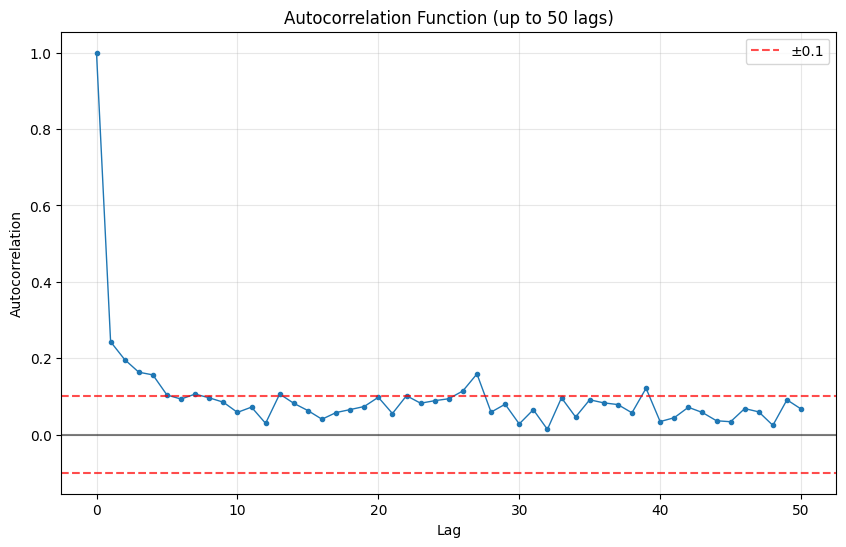

array([1.        , 0.24312892, 0.19631337, 0.16324966, 0.15625235,
       0.10358087, 0.09295136, 0.10596737, 0.0960966 , 0.08473761,
       0.05801879, 0.07180345, 0.02933257, 0.10612909, 0.08180687,
       0.06279575, 0.04012953, 0.05754535, 0.06535911, 0.07342596,
       0.09765392, 0.05501716, 0.10168715, 0.08207252, 0.08863953,
       0.09374437, 0.1142174 , 0.15875237, 0.05867346, 0.07938894,
       0.02778004, 0.06508135, 0.01343843, 0.09618934, 0.04601806,
       0.09102261, 0.08295087, 0.07850377, 0.05686423, 0.12124113,
       0.0339159 , 0.04406447, 0.07137254, 0.05773594, 0.0360813 ,
       0.03358553, 0.06803094, 0.05934443, 0.02405595, 0.09092901,
       0.0669244 ])

In [12]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

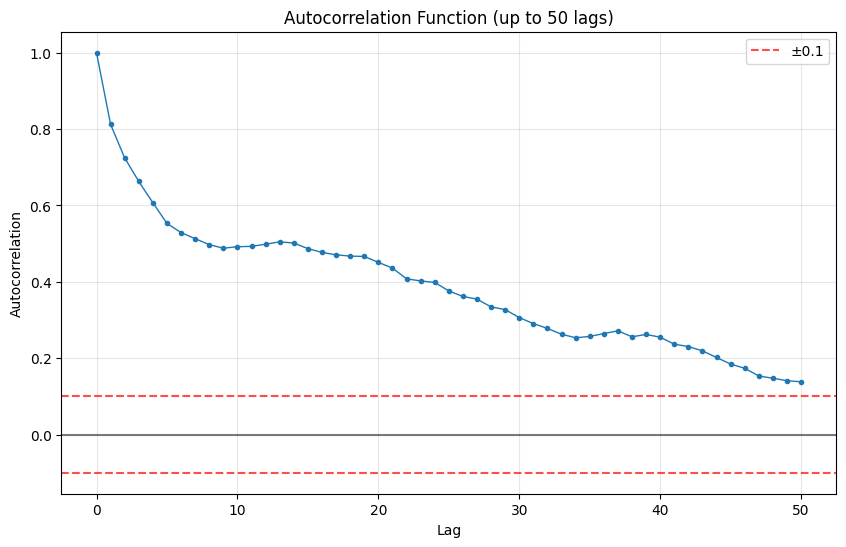

array([1.        , 0.81222728, 0.72442264, 0.66275042, 0.60711972,
       0.55295384, 0.52903215, 0.51287953, 0.49746435, 0.48797693,
       0.49194235, 0.49282765, 0.49851254, 0.50471094, 0.50148297,
       0.48693753, 0.47707426, 0.47075317, 0.46731655, 0.46651508,
       0.45087796, 0.43603373, 0.40793115, 0.40229746, 0.39847943,
       0.37611692, 0.36167989, 0.35473167, 0.3343079 , 0.32731976,
       0.30638789, 0.29063699, 0.27798254, 0.2627077 , 0.25352992,
       0.25695106, 0.26445334, 0.27162584, 0.25597764, 0.2621544 ,
       0.255024  , 0.23661883, 0.23053278, 0.21930017, 0.20183461,
       0.18462569, 0.17348346, 0.15345919, 0.14738782, 0.14104101,
       0.13810076])

In [13]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)